In [1]:
import sqlite3
import paramiko
import ftplib
import sys                               #for path                    
import time                              #for time.sleep
import pandas as pd
import numpy as np                       #for np.array
import matplotlib.pyplot as plt

from IPython.display import clear_output
from scipy.interpolate import interp1d   #for piecewise linear
from IPython.display import display
from pathlib import Path

In [2]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [3]:
import TriPhaseController as tpc 

In [4]:
db = tpc.Database()

In [5]:
import ipywidgets as widgets

In [6]:
import pylab as pl
#import bqplot as bq
from IPython import display as cleardisplay

In [7]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [8]:
def create_expanded_button(description, button_style):
    return widgets.Button(description=description, button_style=button_style, layout=widgets.Layout(height='auto', width='auto'))
def create_expanded_display(layout):
    return widgets.Output(layout=layout)

In [9]:
grid = widgets.GridspecLayout(13, 16, height='700px')

grid[:1,2:4] = create_expanded_button('Download data', '')
grid[:1,7:9] = create_expanded_button('Add time info', '')
grid[:1,12:14] = create_expanded_button('Input', '')

grid[1:7,0:3] = create_expanded_display(layout={'border': '1px solid black'})
grid[1:7,3:6] = create_expanded_display(layout={'border': '1px solid black'})
grid[1:7,6:10] = create_expanded_display(layout={'border': '1px solid black'})
grid[1:7,10:16] = create_expanded_display(layout={'border': '1px solid black'})

grid[7:8,7:9] = create_expanded_button('Run model', '')
grid[8:,2:14] = create_expanded_display(layout={'border': '1px solid black'})

In [10]:
import pytz
netherlands = pytz.timezone('Europe/Amsterdam')

import holidays

from wwf.tab.export import *
to_load = load_pandas('PP.pkl')

from fastai.tabular.all import *

# Custom loss for multi-point forecasting

def multiPointLoss(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = F.mse_loss(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = torch.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = torch.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score

learn = load_learner("FNN_multipoint_12p.pth")
learn.model.eval()
print(color.BOLD + 'Graphical User Interface to test the charging demand forecasting model' + color.END)
print('\t 1. DOWNLOAD DATA: Download data from the database through ssh connection and calculate accumulated hourly demand.')
print('\t 2. ADD TIME INFO: Extract information such as hour, day of week, holiday.')
print('\t 3. INPUT: The final data before being normalised.')
print('\t 4. RUN MODEL: Get the output of the model and show it in a graph.')

Graphical Interface to test the charging demand forecasting model
	 1. DOWNLOAD DATA: Download data from the database through ssh connection and calculate accumulated hourly demand.
	 2. ADD TIME INFO: Extract information such as hour, day of week, holiday.
	 3. INPUT: The final data before being normalised.
	 4. RUN MODEL: Get the output of the model and show it in a graph.


In [11]:
pv_df = None
grid_df = None
ev_df = None
ev_df_in = None

def on_download_click_fnc(b):
    global pv_df
    global grid_df
    
    pv_df = db.read_PV_df(4)
    grid_df = db.read_Grid_df(4)
    with grid[1,0]:
        cleardisplay.clear_output(wait=True)
        display(pv_df)
    with grid[1,3]:
        cleardisplay.clear_output(wait=True)
        display(grid_df)
    with grid[1,6]:
        cleardisplay.clear_output(wait=True)
    with grid[1,10]:
        cleardisplay.clear_output(wait=True)
    
        
def on_time_click_fnc(b):
    global pv_df
    global grid_df
    global ev_df
    
    # Get current hour
    hour_now = datetime.today().hour
    
    # Append the row for current hour if there is not one
    new_time = datetime.now().replace(microsecond=0, second=0, minute=0)
    
    if pv_df.index[-1].tz_localize('GMT').tz_convert(netherlands).hour != hour_now:
        new_data = pd.DataFrame(pv_df[-1:].values, index=[new_time], columns=pv_df.columns)
        pv_df = pd.concat([pv_df,new_data])
        
    if grid_df.index[-1].tz_localize('GMT').tz_convert(netherlands).hour != hour_now:
        new_data = pd.DataFrame(grid_df[-1:].values, index=[new_time], columns=grid_df.columns)
        grid_df = pd.concat([grid_df,new_data])
    
    # Calculate the energy demand of previous hours
    ev_df = grid_df.copy()
    ev_df['Energy_kWh'] = pv_df['Energy_kWh'] - grid_df['Energy_kWh']
    
    # Get weekday and hour from time index
    ev_df['weekday']=ev_df.index.tz_localize('GMT').tz_convert(netherlands).day_of_week
    ev_df['hour']=ev_df.index.tz_localize('GMT').tz_convert(netherlands).hour
    
    # Mark the holidays
    ev_df['hols'] = pd.Series(ev_df.index).apply(lambda x: holidays.CountryHoliday('NL').get(x)).values
    
    # Add HAN breaks
    # https://www.hanuniversity.com/en/study-and-living/studying-at-han/academic-calendar/#
    # https://schoolholidayseurope.eu/school-holidays-holland/
    ev_df.loc[(ev_df.index > '2022-05-01 23:00:00') & (ev_df.index < '2022-05-09 00:00:00'), 'hols'] = 'May holiday'
    ev_df.loc[(ev_df.index > '2022-07-10 23:00:00') & (ev_df.index < '2022-08-15 00:00:00'), 'hols'] = 'Summer break'
    ev_df.loc[(ev_df.index > '2022-10-21 23:00:00') & (ev_df.index < '2022-11-01 00:00:00'), 'hols'] = 'Fall holiday'
    ev_df.loc[(ev_df.index > '2022-12-23 23:00:00') & (ev_df.index < '2023-01-09 00:00:00'), 'hols'] = 'Winter break'
    ev_df.loc[(ev_df.index > '2023-02-17 23:00:00') & (ev_df.index < '2023-02-27 00:00:00'), 'hols'] = 'Spring holiday'
    
    with grid[1,6]:
        #cleardisplay.clear_output(wait=True)
        display(ev_df)
        
def on_input_click_fnc(b):
    global ev_df
    global ev_df_in
    
    # Clean the data
    ev_df.loc[ev_df.Energy_kWh < 0,'Energy_kWh'] = 0
    ev_df['is_hol'] = ~ev_df.isna()['hols']
    ev_df['measure'] = 0
    
    # Other information
    ev_df['E_1'] = ev_df['Energy_kWh']
    ev_df['E_2'] = ev_df['Energy_kWh']
    ev_df['E_3'] = ev_df['Energy_kWh']
    ev_df['E_1'] = ev_df.E_1.shift(1)
    ev_df['E_2'] = ev_df.E_2.shift(2)
    ev_df['E_3'] = ev_df.E_3.shift(3)
    
    # Drop un-used data
    ev_df.reset_index(inplace=True, drop=True)
    ev_df.drop(['Energy_kWh','hols'], axis=1, inplace=True)
    
    # Get only the row of previous hour
    ev_df_in = ev_df.iloc[-1:,:].copy()
    ev_df_in.reset_index(inplace=True, drop=True)
    
    # Create dummy data to run the model, the values are not important
    ev_df_in.loc[:,'Energy_kWh'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_1'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_2'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_3'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_4'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_5'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_6'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_7'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_8'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_9'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_10'] = 0.0
    ev_df_in.loc[:,'Energy_kWh_11'] = 0.0
    
    with grid[1,10]:
        #cleardisplay.clear_output(wait=True)
        display(ev_df_in)
        
def on_model_click_fnc(b):
    global ev_df_in
    global to_load
    global learn
    
    # Preprocess data
    to_test = to_load.train.new(ev_df_in)
    to_test.process()
    dls = to_test.dataloaders()
    
    # Predict
    preds,targs = learn.get_preds(dl=dls[0])
    
    # Get current hour
    hour_now = datetime.today().hour
    
    with grid[8,2]:
        #print(preds[0].numpy())
        Xlabels = np.arange(hour_now-3,hour_now+12)%24
        
        pl.clf()
        plt.figure(figsize=(20,5))
        plt.grid()
        #plt.rcParams.update({'font.size': 17})
        plt.title('Predictions of hourly charging demand in the next 12 hours', fontdict={'fontsize': 17}, y=-0.5)
        plt.bar(np.arange(hour_now,hour_now+12),preds[0].numpy())
        plt.bar(np.arange(hour_now-3,hour_now),[ev_df_in['E_3'][0],ev_df_in['E_2'][0],ev_df_in['E_1'][0]])
        plt.xlabel('Time (hour)', position=(1.0, -.1), fontdict={'fontsize': 17})
        plt.ylabel('Energy consumption (kWh)', position=(0.0, 1.1), rotation='horizontal', fontdict={'fontsize': 17})
        plt.xticks(np.arange(hour_now-3,hour_now+12), Xlabels)

        cleardisplay.clear_output(wait=True)
        cleardisplay.display(pl.gcf())

In [12]:
grid[0,2].on_click(on_download_click_fnc)
grid[0,7].on_click(on_time_click_fnc)
grid[0,12].on_click(on_input_click_fnc)
grid[7,8].on_click(on_model_click_fnc)

GridspecLayout(children=(Button(description='Download data', layout=Layout(grid_area='widget001', height='auto…

<Figure size 432x288 with 0 Axes>

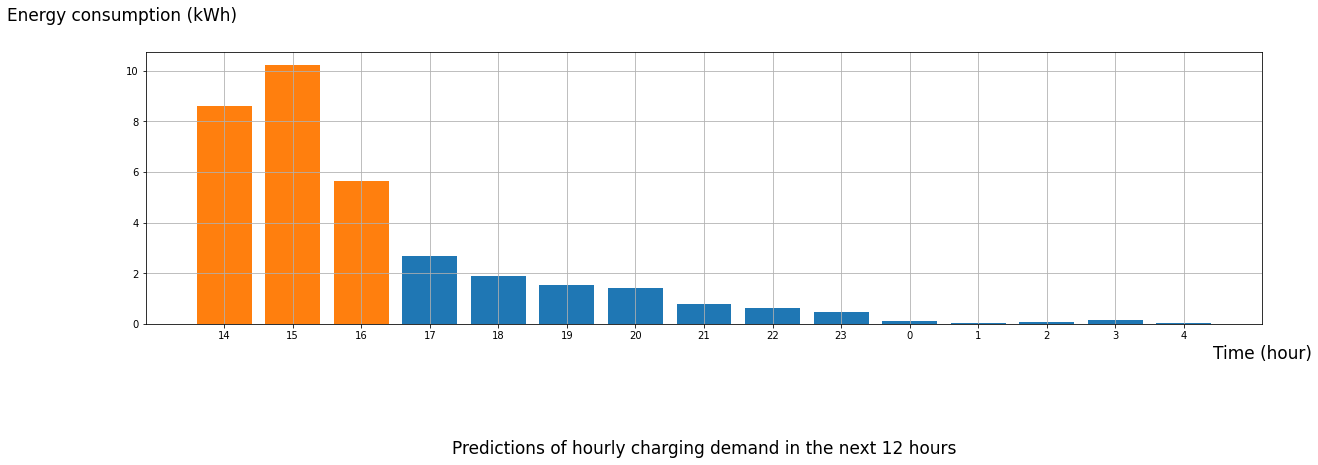

In [13]:
grid